In [61]:
from dataclasses import dataclass
from typing import Tuple, Dict,Mapping, Iterator
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.markov_decision_process import FinitePolicy, StateActionMapping
from rl.markov_process import FiniteMarkovProcess, FiniteMarkovRewardProcess
from rl.distribution import Categorical, Constant
from scipy.stats import poisson
from rl.dynamic_programming import value_iteration_result,value_iteration,almost_equal_vfs
from rl.iterate import converged, iterate,converge
import math

##Define the stateclass
@dataclass(frozen=True)
class FrogState:
    pos: int

# 0 is A,1 is B
FrogStateMapping = StateActionMapping[FrogState, int]


class SimpleFrogMDP(FiniteMarkovDecisionProcess[FrogState, int]):

    def __init__(
        self,
        n:int
    ):
        self.n:int=n
        super().__init__(self.get_action_transition_reward_map())
    def get_action_transition_reward_map(self) -> FrogStateMapping:
        d: Dict[FrogState, Dict[int, Categorical[Tuple[FrogState,float]]]] = {}
        d[FrogState(0)]=None
        d[FrogState(self.n)]=None
        for i in range(1,self.n):
            d1:Dict[int,Categorical[Tuple[FrogState,float]]]={}
            for action in range(2):
                sr_probs_dict:Dict[Tuple[FrogState,float]]={}
                if(action==0):
                    if(i==self.n-1):
                        sr_probs_dict[(FrogState(self.n+1),1.0)]=(self.n-i)/self.n
                    else:
                        sr_probs_dict[(FrogState(self.n+1),0.0)]=(self.n-i)/self.n
                    sr_probs_dict[(FrogState(self.n-1),0.0)]=i/self.n
                if(action==1):
                        for j in range(0,self.n):
                            if(j!=i):
                                sr_probs_dict[(FrogState(j),0.0)]=1/self.n
                        sr_probs_dict[(FrogState(self.n),1.0)]=1/self.n
                d1[action]=Categorical(sr_probs_dict)
            d[FrogState(i)]=d1
        return d
user_gamma=1.0


In [62]:
import matplotlib.pyplot as plt
def generatePolicy(n):
    policies=[]
    for i in range((pow(2,n))):
        binary=str(bin(i))[2:]
        policies.append(list('0'+'0'*(n-len(binary))+str(bin(i))[2:]+'1'))
    return policies

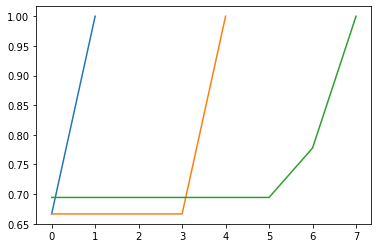

In [63]:
def solve(n):
    si_mdp: FiniteMarkovDecisionProcess[FrogState, int] =SimpleFrogMDP(n=n)
    policies=generatePolicy(n-1)
    best=[0]*(n-1)
    bestpolicy=0
    for i in range(len(policies)):
        fdp: FinitePolicy[FrogState, int] = FinitePolicy(
            {FrogState(j):Constant(int(policies[i][j])) for j in range(0,n+1)}
        )
        implied_mrp: FiniteMarkovRewardProcess[FrogState] =si_mdp.apply_finite_policy(fdp)
        current_prob=implied_mrp.get_value_function_vec(gamma=1.0)
        better=True
        for j in range(len(current_prob)):
            if(current_prob[j]<best[j]):
                better=False
                break
        if(better):
            best=current_prob
            bestpolicy=policies[i]
    return best,bestpolicy
for i in [3,6,9]:
    a,b=solve(i)
    plt.plot(a)